In [1]:
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import functools
import nltk
import xgboost as xgb
import re
import pandas as pd

# Visualization
#!pip install plotly
import plotly.express as px

#!pip install emoji
from emoji import UNICODE_EMOJI

# Sklearn
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.svm import SVC, LinearSVC # for Support Vector Classification baseline model
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # for model evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics


contents = []
with open("rumour-annotation-2_annotations.json", 'rb') as j:
     contents.append(json.loads(j.read()))

contents2 = []
with open("rumour-annotation-3_annotations.json", 'rb') as j:
     contents2.append(json.loads(j.read()))

contents3 = []
with open("rumour-annotation_annotations.json", 'rb') as j:
     contents3.append(json.loads(j.read()))

contents4 = []
with open("rumour-annotation-4_annotations.json", 'rb') as j:
     contents4.append(json.loads(j.read()))

In [2]:
annotations = contents[0]["examples"]

classnames = []
for i in range(0,len(annotations)):
    classnames.append(annotations[i]["classifications"][0]["classname"])

In [3]:
annotations2 = contents2[0]["examples"]

classnames2 = []
for i in range(0,len(annotations2)):
    classnames2.append(annotations2[i]["classifications"][0]["classname"])

In [4]:
annotations3 = contents3[0]["examples"]

classnames3 = []
for i in range(0,len(annotations3)):
    classnames3.append(annotations3[i]["classifications"][0]["classname"])

In [5]:
annotations4 = contents4[0]["examples"]

classnames4 = ["Rumour"]
for i in range(1,len(annotations4)):
    classnames4.append(annotations4[i]["classifications"][0]["classname"])

In [6]:
df = pd.read_csv("DutchTwitterData.csv", sep="\t").drop('Unnamed: 0',axis=1)

/tmp/ipykernel_13243/613116759.py:1: DtypeWarning: Columns (0,1,2,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("DutchTwitterData.csv", sep="\t").drop('Unnamed: 0',axis=1)


In [7]:
sample1 = [annotations[i]["content"] for i in range(len(annotations))]
sample2 = [annotations2[i]["content"] for i in range(len(annotations2))]
sample3 = [annotations3[i]["content"] for i in range(len(annotations3))]
sample4 = [annotations4[i]["content"] for i in range(len(annotations4))]

sample = sample1 + sample2 + sample3 + sample4

annotations = annotations + annotations2 + annotations3 + annotations4

In [8]:
#adding rumours 

sample = [sample1, sample2, sample3, sample4]
annotators = ["A", "B", "C", "D"]
texts = list(df["text"])
a = []
for i in range(len(texts)):
    value = None
    for s in range(len(sample)):
        if texts[i] in sample[s]:
            if annotations[sample[s].index(texts[i])]["classifications"] != []:
                label = annotations[sample[s].index(texts[i])]["classifications"][0]["classname"]
                value = annotators[s]
                
    #print(value)
    if value == None:
        a.append("n.a.")
    else:
        a.append(str(value))
        
df["annotator"] = a
df

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label,annotator
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0,n.a.
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0,n.a.
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0,n.a.
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0,n.a.
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,...,0.000800,0.0,0.0,0.648938,0.981257,#buitenhof\n\nGaaaaaaaaf land NL\n\n#rutte @Mi...,#jinek,-1#jinek,-1.0,n.a.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494074,0.0,0.0,0.0,0.0,0.993064,0.000000,0.0,0.049566,0.000000,1.0,...,0.000000,0.0,0.0,1.000000,0.006306,Slim Beleggen - Weekend TV http://bit.ly/deDzP...,#inflatie,-1#inflatie,-1.0,n.a.
494075,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0,n.a.
494076,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0,n.a.
494077,0.0,0.0,0.0,0.0,0.997605,0.000000,0.0,0.008261,0.000000,1.0,...,0.000000,0.0,0.0,1.000000,0.002177,@desmodus Lastig. En het erge vind ik dus dat ...,#inflatie,-1#inflatie,-1.0,n.a.


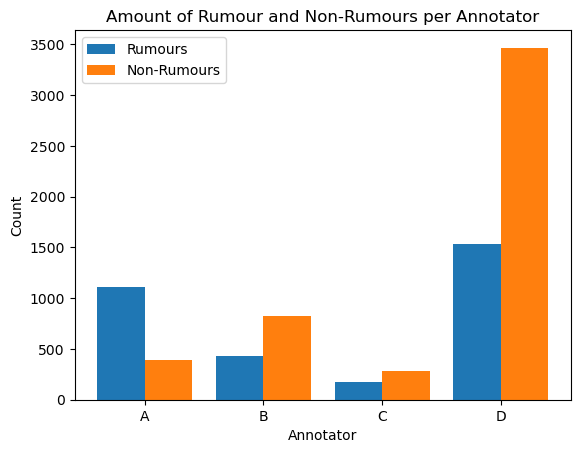

<Figure size 640x480 with 0 Axes>

In [12]:
annotators = np.array(["A","B","C","D"])
_, rumour_counts = np.unique(df[df["label"]==1]["annotator"], return_counts=True)
_, nonrumour_counts = np.unique(df[df["label"]==0]["annotator"], return_counts=True)
X_axis = np.arange(len(annotators))

plt.bar(X_axis - 0.2, rumour_counts, 0.4, label = 'Rumours')
plt.bar(X_axis + 0.2, nonrumour_counts, 0.4, label = 'Non-Rumours')

fig1 = plt.gcf()
plt.xticks(X_axis, annotators)
plt.xlabel("Annotator")
plt.ylabel("Count")
plt.title("Amount of Rumour and Non-Rumours per Annotator")
plt.legend()
plt.show()
plt.draw()
fig1.savefig("Annotators.pdf")

In [15]:
np.unique(df[df["label"]==1]["hashtag"], return_counts=True)

(array(['#inflatie', '#jinek', '#vleestaks'], dtype=object),
 array([2828,  294,  120]))

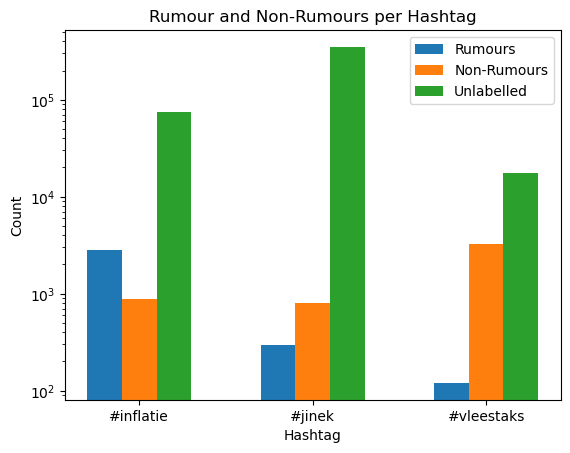

<Figure size 640x480 with 0 Axes>

In [16]:
hashtags = np.array(["#inflatie", "#jinek", "#vleestaks"])
_, r_h_counts = np.unique(df[df["label"]==1]["hashtag"], return_counts=True)
_, nr_h_counts = np.unique(df[df["label"]==0]["hashtag"], return_counts=True)
_, u_h_counts = np.unique(df[df["label"]==-1]["hashtag"], return_counts=True)

X_axis = np.arange(len(hashtags))

plt.bar(X_axis - 0.2, r_h_counts, 0.2, label = 'Rumours')
plt.bar(X_axis + 0, nr_h_counts, 0.2, label = 'Non-Rumours')
plt.bar(X_axis + 0.2, u_h_counts, 0.2, label = 'Unlabelled')

fig1 = plt.gcf()
plt.xticks(X_axis, hashtags)
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.yscale('log')
plt.title("Rumour and Non-Rumours per Hashtag")
plt.legend()
plt.show()
plt.draw()
fig1.savefig("Hashtags_A.pdf")

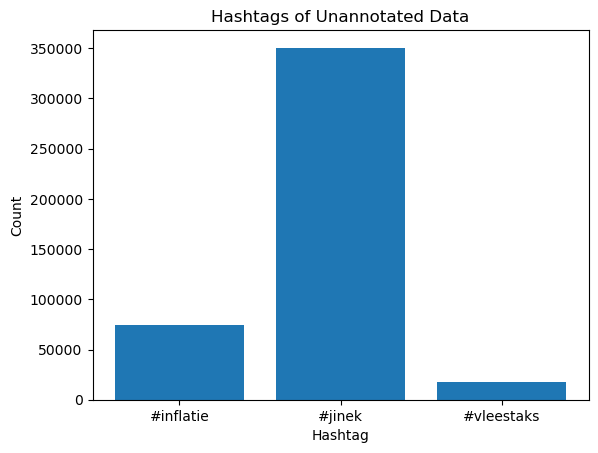

<Figure size 640x480 with 0 Axes>

In [17]:
hashtags = np.array(["#inflatie", "#jinek", "#vleestaks"])
_, u_h_counts = np.unique(df[df["label"]==-1]["hashtag"], return_counts=True)

X_axis = np.arange(len(hashtags))

plt.bar(X_axis, u_h_counts, label = 'Unlabelled')

fig1 = plt.gcf()
plt.xticks(X_axis, hashtags)
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.title("Hashtags of Unannotated Data")
plt.show()
plt.draw()
fig1.savefig("Hashtags_U.pdf")

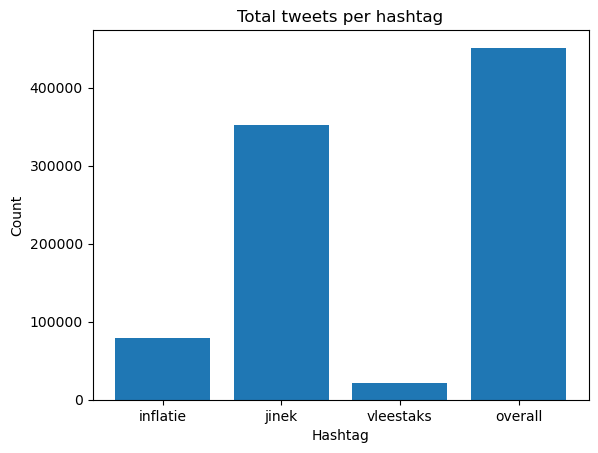

<Figure size 640x480 with 0 Axes>

In [18]:
_, r_h_counts = np.unique(df[df["label"]==1]["hashtag"], return_counts=True)
_, nr_h_counts = np.unique(df[df["label"]==0]["hashtag"], return_counts=True)
_, u_h_counts = np.unique(df[df["label"]==-1]["hashtag"], return_counts=True)

inflatie = sum([x[0] for x in [r_h_counts,nr_h_counts,u_h_counts]])
jinek = sum([x[1] for x in [r_h_counts,nr_h_counts,u_h_counts]])
vleestaks = sum([x[2] for x in [r_h_counts,nr_h_counts,u_h_counts]])
alll = sum([inflatie, jinek, vleestaks])

fig1 = plt.gcf()
plt.bar(["inflatie", "jinek", "vleestaks", "overall"], [inflatie, jinek, vleestaks,alll])
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.title("Total tweets per hashtag")
plt.show()
plt.draw()
fig1.savefig("tweetsperhashtag.pdf")